In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv(r"C:\Users\gaeta\Documents\Ynov\open_data\challenge\machine_learning\df_ti_pe_complet_preformatted_calculmeter_population_prct_pe3.csv")

# Assurez-vous que 'date_mutation' est bien au format datetime
df['date_mutation'] = pd.to_datetime(df['date_mutation'])
#df = df.astype({col: 'float32' for col in df.select_dtypes(include='float64').columns})

# Filtrer les données pour l'entraînement (2019 à septembre 2023) et le test (octobre à décembre 2023)
start_date_train = '2022-01-01'
end_date_train = '2023-09-30'
start_date_test = '2023-10-01'
end_date_test = '2023-12-29'

df_train = df[(df['date_mutation'] >= start_date_train) & (df['date_mutation'] <= end_date_train)]
df_test = df[(df['date_mutation'] >= start_date_test) & (df['date_mutation'] <= end_date_test)]

# Utiliser 'date_mutation' comme index
df_train.set_index('date_mutation', inplace=True)
df_test.set_index('date_mutation', inplace=True)

# Agréger les données par intervalles de 2 jours
y_train = df_train['PE']
y_test = df_test['PE']


In [2]:
y_train.astype('int64')
y_test.astype('int64')
y_train = df_train['PE'].resample('D').sum()
y_test = df_test['PE'].resample('D').sum()
print(y_train.isna().unique())
print(y_test.isna().unique())

[False]
[False]


Outliers détectés:
date_mutation
2022-06-17    23302353
2022-06-30    28941550
2022-10-27    34172264
2022-11-29    37236162
2022-12-22    66276817
2022-12-30    64125983
2023-04-12    44971353
2023-06-27    29956467
2023-06-28    33823186
2023-06-30    33106059
2023-07-21    34720365
2023-07-28    69221754
2023-09-28    26537145
Name: PE, dtype: int64


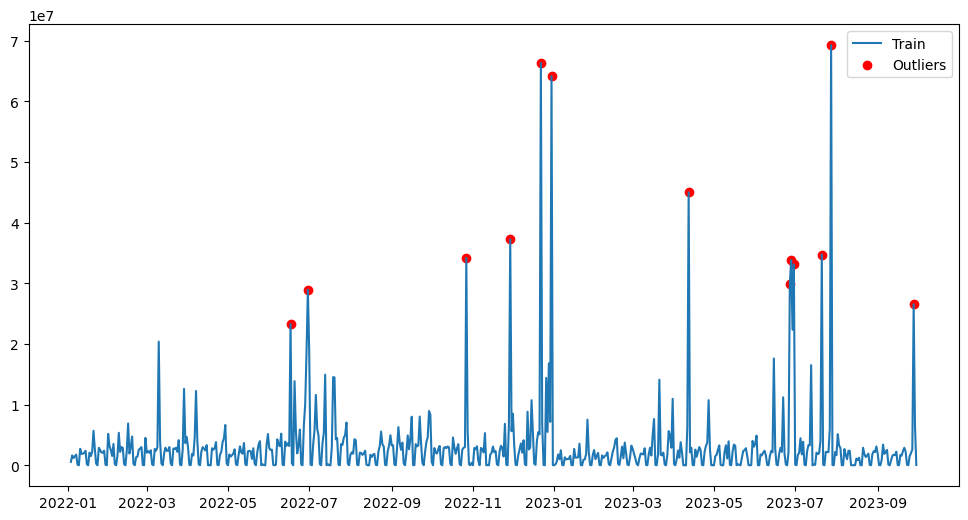

In [3]:
# Détection des outliers
threshold = 3  # Définir le seuil pour détecter les outliers (ex. 3 écarts-types)
mean_y_train = y_train.mean()
std_y_train = y_train.std()
outliers = y_train[(y_train - mean_y_train).abs() > threshold * std_y_train]

# Afficher les outliers
print("Outliers détectés:")
print(outliers)

# Visualiser les données avec les outliers
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.legend()

In [4]:
# Remplacer les outliers par la médiane des valeurs voisines
#y_train_cleaned = y_train.copy()
#for idx in outliers.index:
#    # Calculer l'excédent de l'outlier par rapport à la médiane des 14 jours voisins
#    start_idx = idx - pd.Timedelta(days=7)
#    end_idx = idx + pd.Timedelta(days=7)
#    window = y_train[start_idx:end_idx].drop(idx)
#    median_val = window.median()
#    excess = y_train_cleaned.loc[idx] - median_val

    # Répartir l'excédent sur les 14 jours de la fenêtre
#    if len(window) > 0:  # Assurez-vous qu'il y a suffisamment de jours dans la fenêtre
#        y_train_cleaned.loc[start_idx:end_idx] += excess / len(window)
#        y_train_cleaned.loc[idx] = median_val

# Vérifier les valeurs nettoyées
#plt.figure(figsize=(12, 6))
#plt.plot(y_train, label='Original Train')
#plt.plot(y_train_cleaned, label='Cleaned Train')
#plt.legend()
#plt.show()

In [5]:
# Remplacer les outliers par la médiane des valeurs voisines
#threshold = 3  # Définir le seuil pour détecter les outliers (ex. 3 écarts-types)
#mean_y_test = y_test.mean()
#std_y_test = y_test.std()
#outliers = y_test[(y_test - mean_y_test).abs() > threshold * std_y_test]

#y_test_cleaned = y_test.copy()
#for idx in outliers.index:
    # Calculer l'excédent de l'outlier par rapport à la médiane des 14 jours voisins
#    start_idx = idx - pd.Timedelta(days=7)
#    end_idx = idx + pd.Timedelta(days=7)
#    window = y_test[start_idx:end_idx].drop(idx)
#    median_val = window.median()
#    excess = y_test_cleaned.loc[idx] - median_val

    # Répartir l'excédent sur les 14 jours de la fenêtre
#    if len(window) > 0:  # Assurez-vous qu'il y a suffisamment de jours dans la fenêtre
#        y_test_cleaned.loc[start_idx:end_idx] += excess / len(window)
#        y_test_cleaned.loc[idx] = median_val

# Vérifier les valeurs nettoyées
#plt.figure(figsize=(12, 6))
#plt.plot(y_test, label='Original test')
#plt.plot(y_test_cleaned, label='Cleaned test')
#plt.legend()
#plt.show()

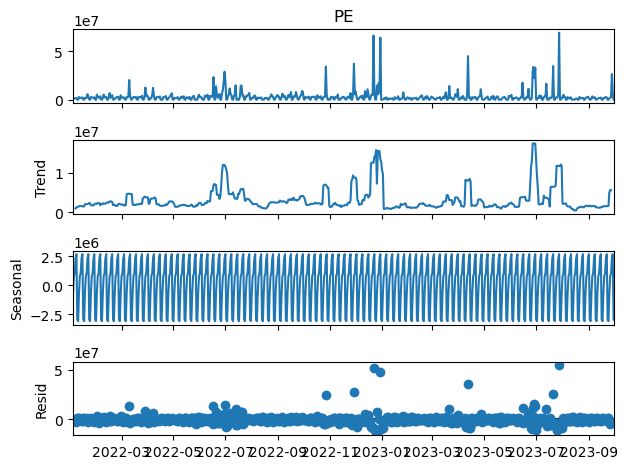

In [6]:

res = seasonal_decompose(y_train, model='additive', period=7)
res.plot()
plt.show()

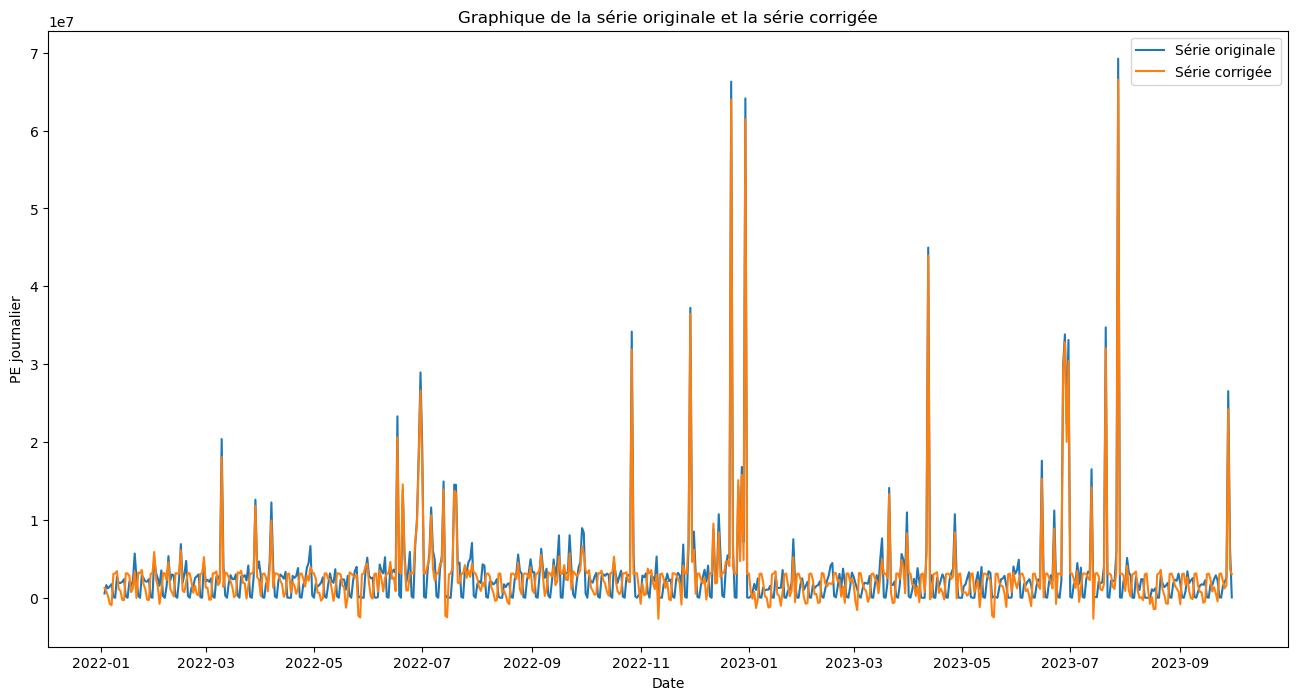

In [7]:

# Ici on utilise la transformée en log on est donc dans un modèle additif
plt.figure(figsize=(16, 8))
mult=seasonal_decompose(y_train, model='additive', period=7)
# On soustrait les coefficients saisonniers à la série airpasslog
x_cvs=y_train- mult.seasonal

# On affiche la série

plt.plot(y_train, label='Série originale')

plt.plot(x_cvs, label='Série corrigée')

plt.title('Graphique de la série originale et la série corrigée')

plt.xlabel('Date')

plt.ylabel('PE journalier')

plt.legend()

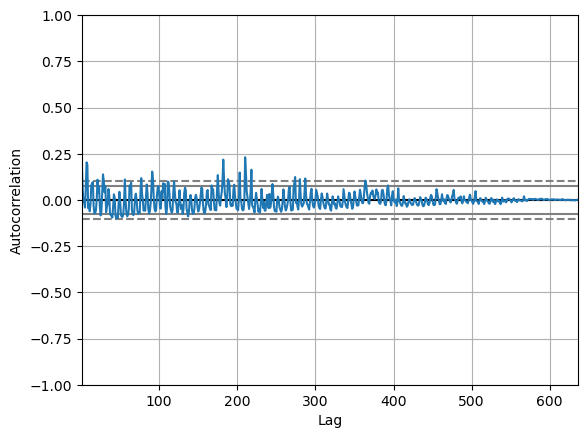

In [8]:
pd.plotting.autocorrelation_plot(y_train);

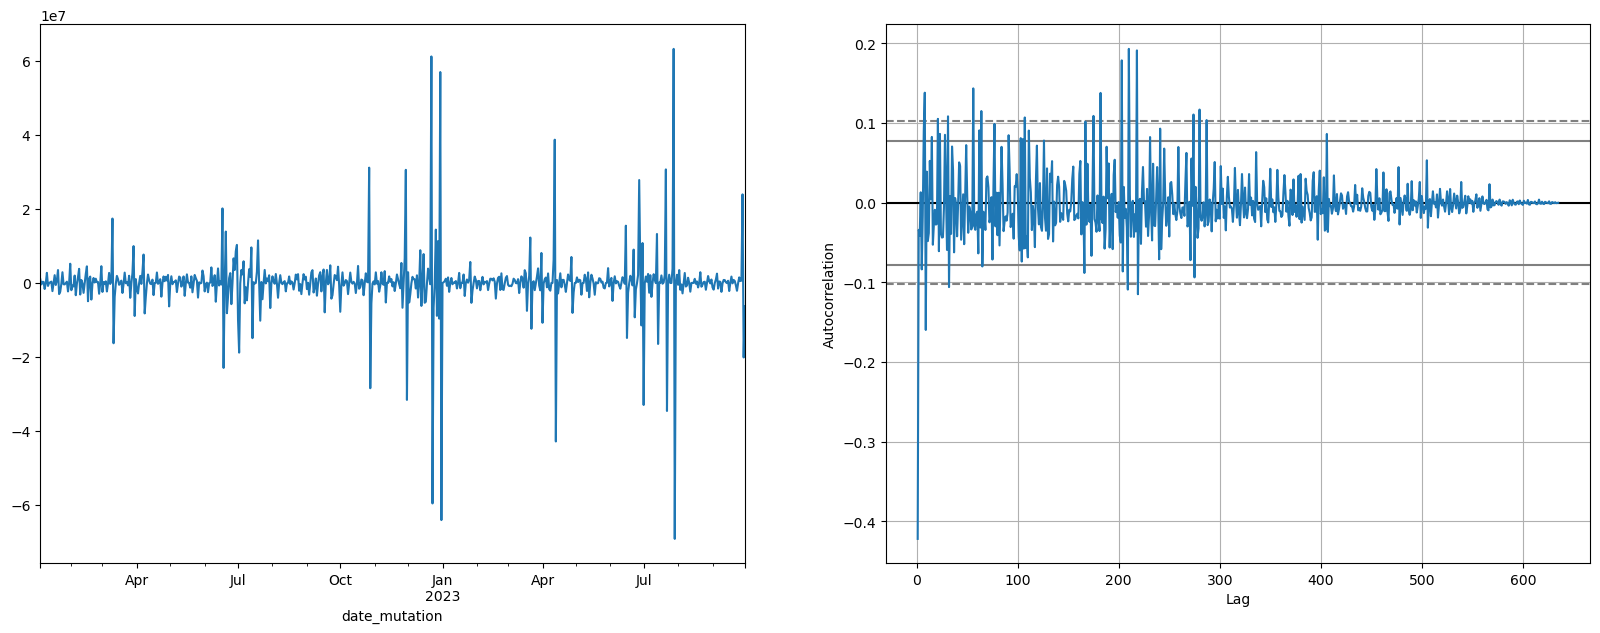

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Création de la figure et des axes
airpasslog_1 = y_train.diff().dropna() # Différenciation ordre 1
airpasslog_1.plot(ax = ax1) #Série temporelle différenciée
pd.plotting.autocorrelation_plot(airpasslog_1, ax = ax2); #Autocorrélogramme de la série différenciée

In [10]:

_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(airpasslog_1)
p_value
#p-value supérieure à 5, on ne peut pas rejeter l'hypothèse selon laquelle l'hypothèse n'est pas stationnaire. Il y a une saisonalité mais qu'on ne semble pas voir à vu d'oeil
#On va donc réessayer avec une saisonalité de l'ordre d'une semaine

5.754723558543438e-20

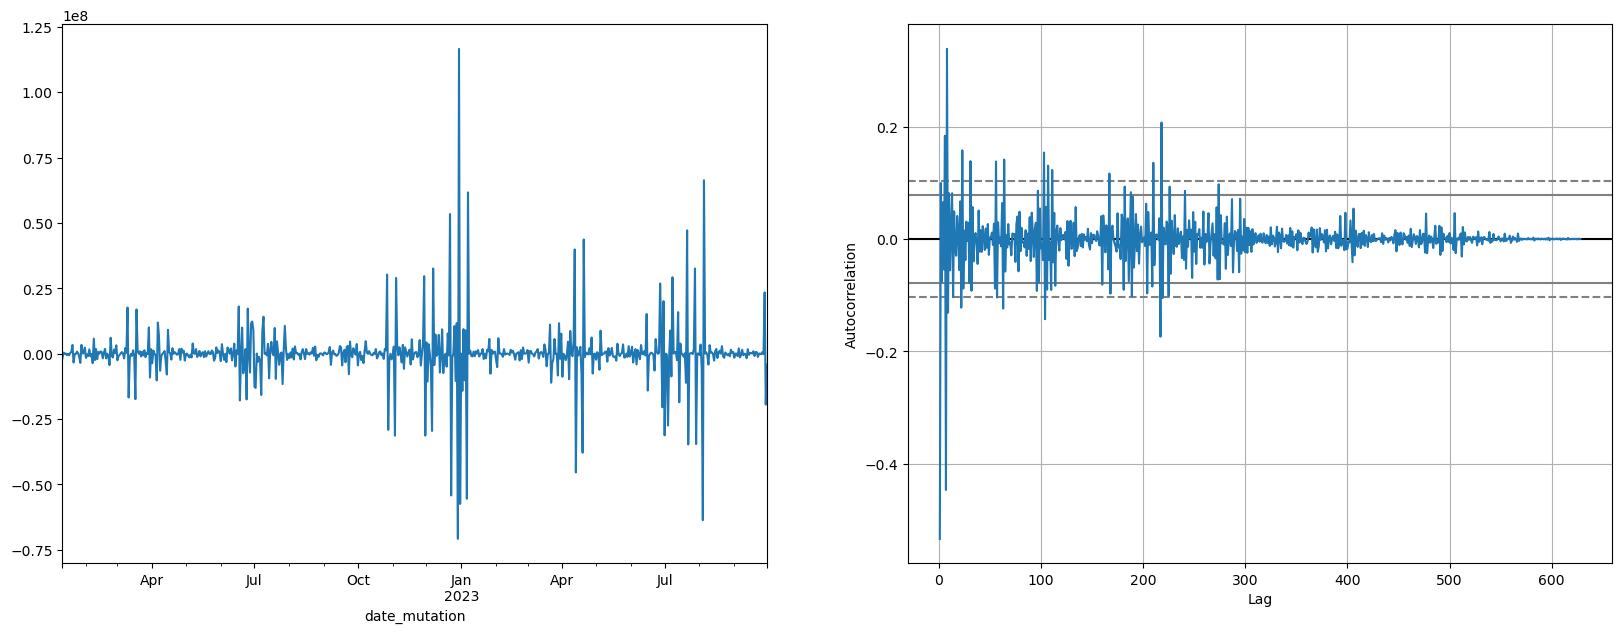

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Création de la figure et des axes
airpasslog_2 = airpasslog_1.diff(periods = 7).dropna() # Différenciation ordre 2 avec une saisonalité de période 7
airpasslog_2.plot(ax = ax1) #Série temporelle différenciée
pd.plotting.autocorrelation_plot(airpasslog_2, ax = ax2); #Autocorrélogramme de la série différenciée

In [12]:
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(airpasslog_2)
p_value


1.6241030129745135e-12

In [13]:
#En ayant différencié une fois avec une période de 1 et une autre selon la saisonnalité avec une période de 12, nous avons stationnarisé la série temporelle.
#Il est désormais possible de la modéliser en utilisant un processus ARMA.

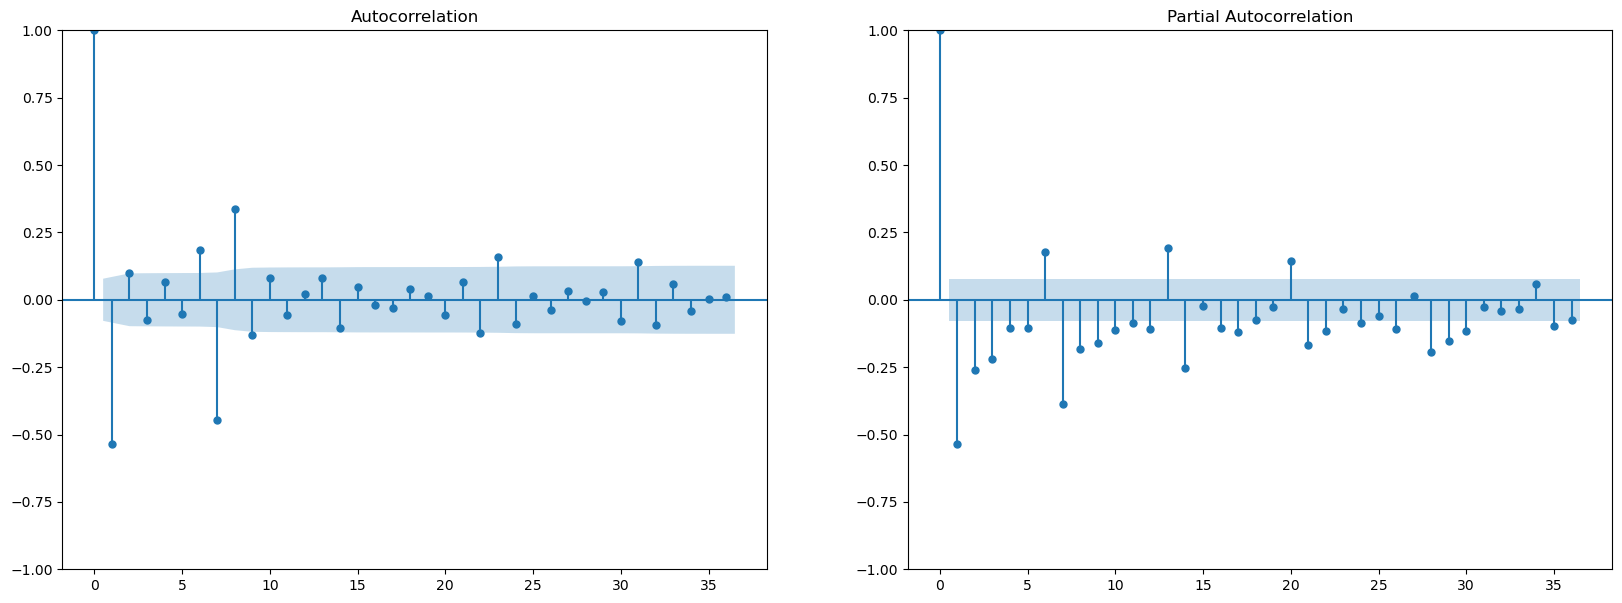

In [14]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
plot_acf(airpasslog_2, lags = 36, ax=ax1)
plot_pacf(airpasslog_2, lags = 36, ax=ax2)
plt.show()

In [15]:
#Pour l'autocorrélation simple, on observe une forte valeur au  deuxième mais diminue fortement plus tard. 
#Ainsi la règle sur l'ACF pour un processus  MA(1) est respectée.
#Pour l'autocorrélation partielle, le  12ème pic est encore significatif. Le  24ème est dans la limite de zone de non significativité et le  
#36ème est à nouveau important. Il n'y pas de coupure mais plutôt une décroissance. Ainsi la règle sur la PACF pour un processus  MA(1) est aussi respectée.

C:\Users\gaeta\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\gaeta\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gaeta\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


R^2 score: 0.28814341891326756
Mean Squared Error: 50367413572245.125
Mean Absolute Error: 3387854.249944535


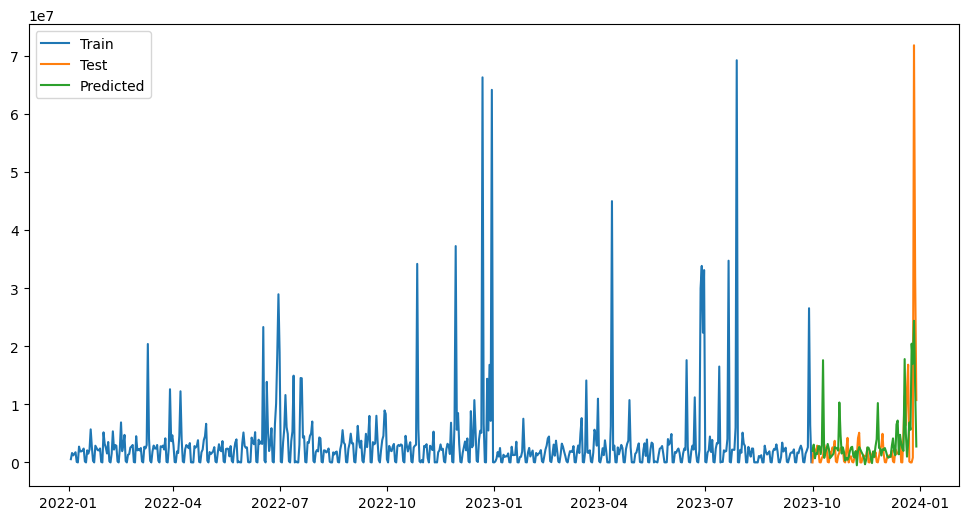

In [16]:
# Longueur des séries
n_train = len(y_train)
n_test = len(y_test)
n_total = n_train + n_test

# Créer la composante saisonnière avec un décalage
# Décalage pour que la partie haute arrive à la fin de la période de test
phase_shift = n_test % 123
season_123_total = np.sin(2 * np.pi * (np.arange(n_total) + phase_shift*2-10) / 123)

# Séparer les exogènes pour la période d'entraînement et de test

def exog_func(date1, date2, y_train):
    if isinstance(date1, str):
        date1 = datetime.strptime(date1, '%Y-%m-%d').date()
        date2 = datetime.strptime(date2, '%Y-%m-%d').date()
    
    # Calculer la différence en jours entre date2 et date1
    difference_jours = (date2 - date1).days + 1
    print(difference_jours)
    # Sélectionner les données exogènes de y_train pour la période spécifiée
    exog_train1 = y_train.loc['2023-01-01':'2023-04-10']
    
    # Répéter les données exogènes pour couvrir toute la période de date1 à date2
    tableau_repete = np.tile(exog_train1, int(np.ceil(difference_jours / len(exog_train1))))
    
    # Tronquer le tableau répété à la longueur exacte de difference_jours
    tableau_final = tableau_repete[:difference_jours]
    print(len(tableau_final))
    # Créer l'index des dates pour les données exogènes
    index_dates = pd.date_range(start=date1, end=date2, freq='D')
    
    # Créer le DataFrame exog_train avec les données exogènes répétées et l'index de dates
    exog_train = pd.DataFrame({'season_123': tableau_final}, index=index_dates)
    
    return exog_train
#exog = exog_func(y_train.index[0],y_train.index[-1],y_train)
#exog_test = pd.DataFrame({'season_123': season_123_total[n_train:]})
#exog_test.index = y_test.index

# Ajuster le modèle SARIMAX avec les variables exogènes d'entraînement
model = sm.tsa.SARIMAX(x_cvs, 
                       order=(2, 0, 1), 
                       seasonal_order=(0, 1, 1, 181))
sarima_fit = model.fit()

# Faire des prédictions avec les variables exogènes de test
#exog = exog_func(y_test.index[0],y_test.index[-1],y_train)
y_pred = sarima_fit.predict(start=y_test.index[0], end=y_test.index[-1])

# Évaluer le modèle
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Afficher les prédictions
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [17]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  636
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 181)   Log Likelihood               -7831.420
Date:                             Mon, 08 Jul 2024   AIC                          15672.840
Time:                                     10:07:56   BIC                          15693.441
Sample:                                 01-03-2022   HQIC                         15680.956
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9698      0.114      8.490      0.000       0.746       1.194
ar.L2          0.0071      0.090      0.079      0.937      -0.169       0.184
ma.L1         -0.9466      0.100     -9.491      0.000      -1.142      -0.751
ma.S.L181     -0.6385      0.048    -13.384      0.000      -0.732      -0.545
sigma2      6.748e+13   2.26e-15   2.99e+28      0.000    6.75e+13    6.75e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             33172.87
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             5.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.85e+43. Standard errors may be unstable.
"""

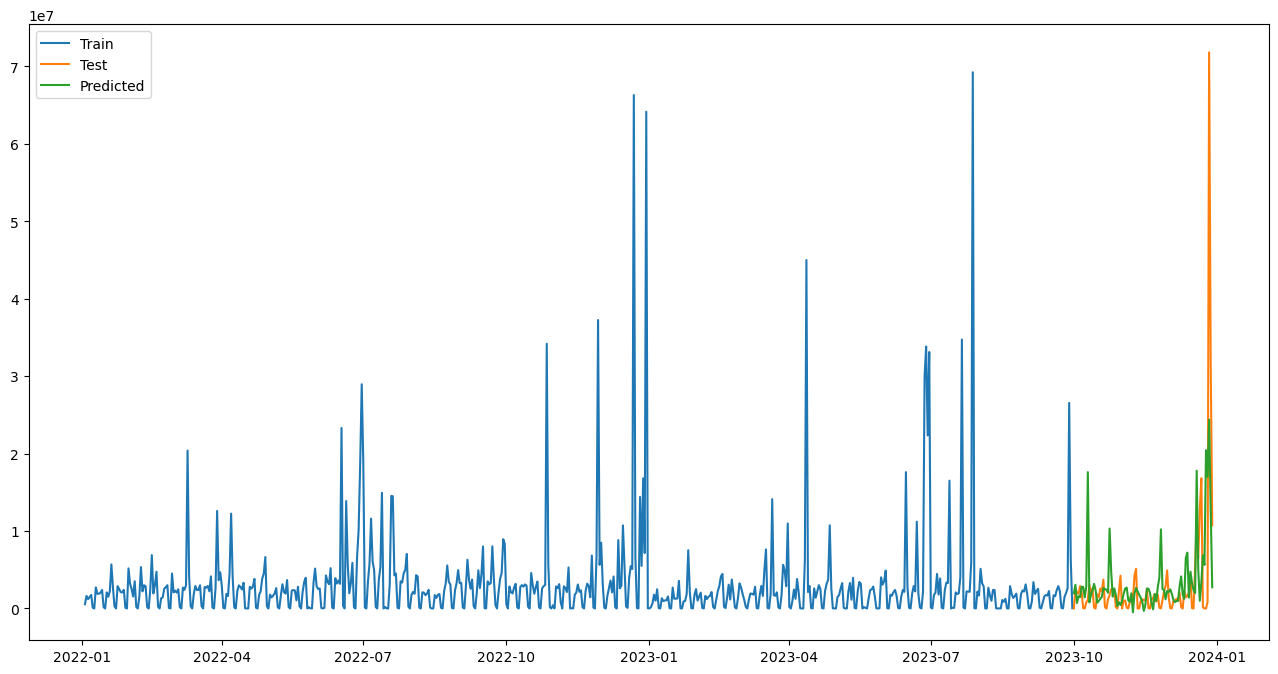

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [19]:
y_test.mean()

3088329.611111111

In [20]:
y_pred.mean()

3404300.521407273

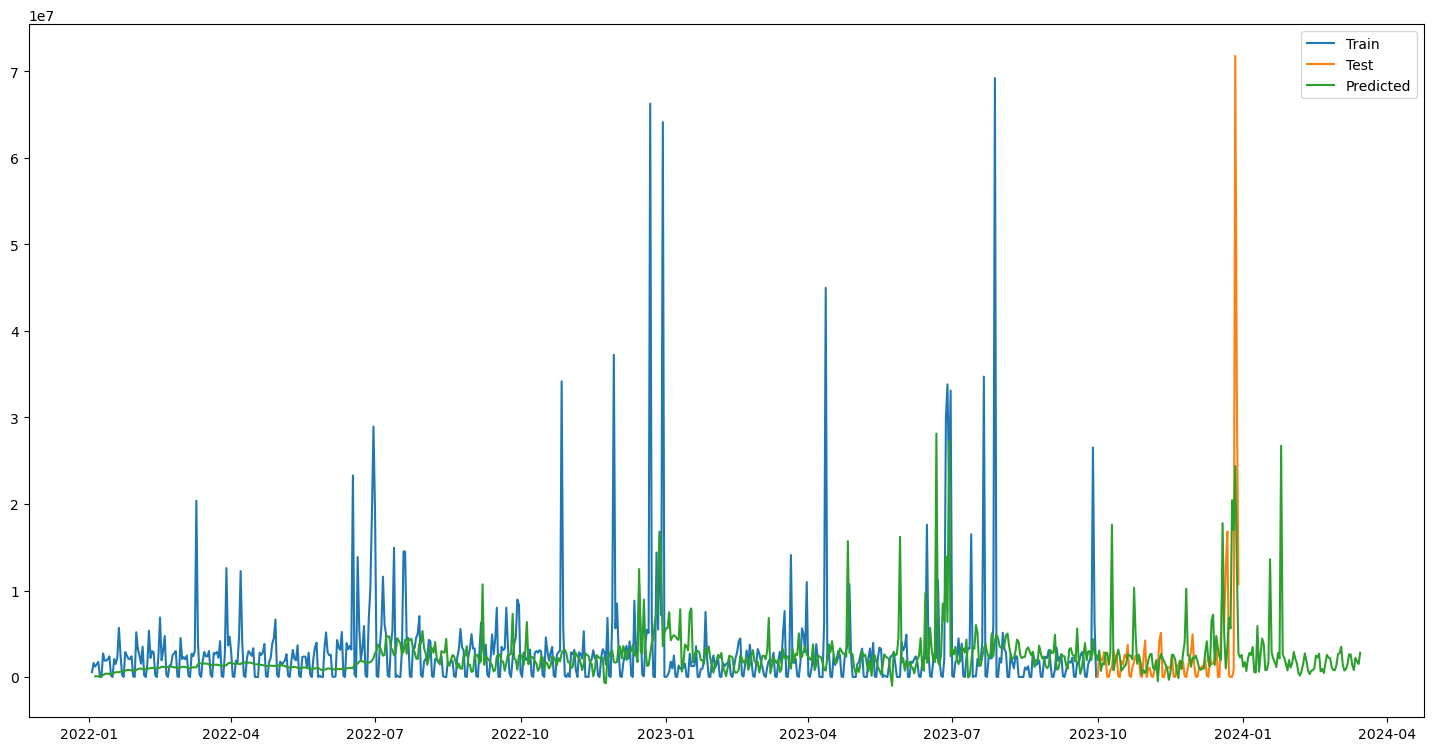

In [23]:
#exog = exog_func('2022-01-05','2024-03-15',y_train)
y_predict = sarima_fit.predict(start='2022-01-05', end='2024-03-15')
plt.figure(figsize=(18, 9))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_predict, label='Predicted')
plt.legend()
plt.show()